C:\Users\HP\AppData\Local\Temp\ipykernel_15228\314231664.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spot_price = stock.history(period="1d")["Close"][0]


Spot Price: $692.60498046875
   Strike  Time        IV
0   580.0     3  0.735842
1   600.0     3  0.607426
2   605.0     3  0.585453
3   617.0     3  0.511479
4   640.0     3  0.517461


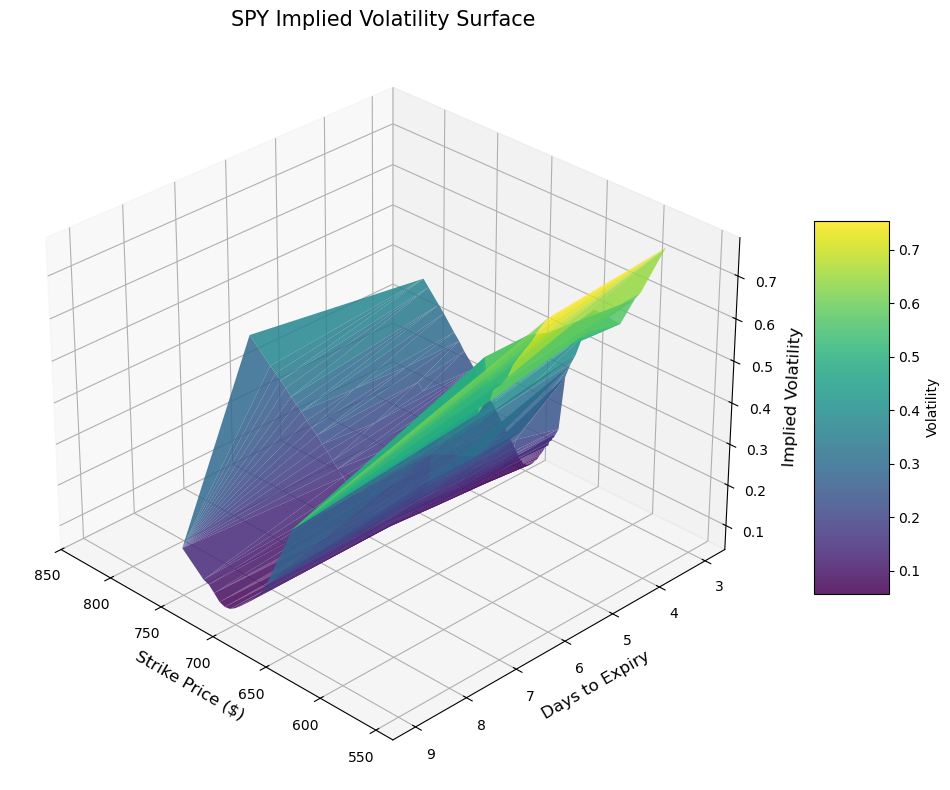

In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import numpy as np

ticker = "SPY"
stock = yf.Ticker(ticker)

spot_price = stock.history(period="1d")["Close"][0]
print(f"Spot Price: ${spot_price:}")

expirations = stock.options
target_expiration = expirations[:6] 

vol_data = []
current_date = datetime.now()

for exp in target_expiration:
    chain = stock.option_chain(exp)
    calls = chain.calls
    
    exp_date = datetime.strptime(exp, "%Y-%m-%d")
    days_left = (exp_date - current_date).days
    
    if days_left < 1:
        continue
    
    calls = calls[(calls['impliedVolatility'] > 0.01) & (calls['strike'] > spot_price * 0.8) &(calls['strike'] < spot_price * 1.2)]
    
    for _,row in calls.iterrows():
        vol_data.append({
            'Strike': row['strike'],
            'Time': days_left,             
            'IV': row['impliedVolatility']})

df_vol = pd.DataFrame(vol_data)
print(df_vol.head())

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X = df_vol['Strike']
Y = df_vol['Time']
Z = df_vol['IV']

surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.85)

ax.set_title(f'{ticker} Implied Volatility Surface', fontsize=15)
ax.set_xlabel('Strike Price ($)', fontsize=12)
ax.set_ylabel('Days to Expiry', fontsize=12)
ax.set_zlabel('Implied Volatility', fontsize=12)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Volatility')

ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.savefig('IV.png')
plt.show()
